In [1]:
import pandas as pd
import numpy as np
from joblib import dump, load
import time
import datetime
import operator

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import callbacks

from matplotlib import pyplot as plt

In [2]:
%load_ext tensorboard

### Some useful functions

In [3]:
def get_confusion_matrix(true_pos, false_pos, true_neg, false_neg):
    conf_matrix = np.array([
                            [true_pos, false_pos],
                            [false_neg, true_neg]
                           ])
    
    return pd.DataFrame(conf_matrix, columns=['1', '0'], index=['1', '0'])

In [4]:
def learning_plot(model, metric):
    
    fig = plt.figure()
    
    fig = plt.plot(model.history[metric], color='black')
    fig = plt.plot(model.history['val_'+metric], color='blue')

    plt.title('Changes in {} over training run'.format(metric))
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    
    plt.legend(['train', 'val'], loc='upper right')
    
    return fig

In [5]:
def learning_recall(model, positives_flag=True):
    
    if positives_flag:
        recall = [tp / (tp+fn) for tp, fn in zip(model.history['true_positives'], model.history['false_negatives'])]
        val_recall = [tp / (tp+fn) for tp, fn in zip(model.history['val_true_positives'], model.history['val_false_negatives'])]
        recall_type = 'positive'
    else:
        recall = [tn / (tn+fp) for tn, fp in zip(model.history['true_negatives'], model.history['false_positives'])]
        val_recall = [tn / (tn+fp) for tn, fp in zip(model.history['val_true_negatives'], model.history['val_false_positives'])]
        recall_type = 'negative'
        
    fig = plt.figure()
    
    fig = plt.plot(recall, color='black')
    fig = plt.plot(val_recall, color='blue')
    
    plt.title('Changes in {} recall rate over training run.'.format(recall_type))
    plt.xlabel('Epoch')
    plt.ylabel('{} recall rate'.format(recall_type))
    
    return fig

In [6]:
def random_search_models(num_models, input_dims, compile_metrics, seed):
    
    np.random.seed(seed)
    
    all_models = []
    
    for m in range(num_models): 
        
        num_hidden_layers = np.random.randint(1, 6)
        all_models.append(build_model(num_hidden_layers, input_dims, compile_metrics))
    
    return all_models

def build_layers(num_layers, input_dims):

    layers = []
    
    for i in range(num_layers):
        
        num_units = np.random.randint(2, 27)
        reg_val = 10**(-4*np.random.rand())
        if i==0:
            layers.append(Dense(
                                units = num_units,
                                input_dim = input_dims,
                                activation = 'relu',
                                kernel_regularizer = l2(l2=reg_val)
                               ))
        else:
            layers.append(Dense(
                                units = num_units,
                                activation = 'relu',
                                kernel_regularizer = l2(l2=reg_val)
                               ))
    reg_val = 10**(-4*np.random.rand())
    layers.append(Dense(
                        units = 1,
                        activation = 'sigmoid',
                        kernel_regularizer = l2(l2=reg_val)
                       ))
    return layers

def build_model(num_hidden_layers, input_dims, compile_metrics):

    model = Sequential()
    
    layers = build_layers(num_hidden_layers, input_dims)
    for l in layers:
        model.add(l)
    
    learning_rate = 10**(-4*np.random.rand())
    model.compile(optimizer = Adam(learning_rate), loss='binary_crossentropy', metrics=[compile_metrics])
    
    return model

In [7]:
def get_best_models(model_list, metric, descending, num_models):
    
    m_tuples = []
    for model, history, num in model_list:
        m_tuples.append((model, history, history.history[metric][-1], num))
        
    m_tuples.sort(key=operator.itemgetter(2), reverse=descending)
    
    if num_models:
        return m_tuples[:num_models]
    else:
        return m_tuples

### Load and prepare data

In [8]:
df = pd.read_csv('jazz.csv', sep='|')

In [9]:
# Define features to analyze
features = [
            'danceability',
            'energy',
            'speechiness',
            'acousticness',
            'instrumentalness',
            'liveness',
            'valence',
            'num_samples',
            'end_of_fade_in',
            'loudness',
            'tempo',
            'key',
            'mode',
            'bars_num',
            'bars_duration_var',
            'beats_duration_var',
            'sections_num',
            'sections_duration_mean',
            'sections_duration_var',
            'loudness_var',
            'tempo_var',
            'key_var',
            'mode_var',
            'segments_duration_var',
            'segments_duration_mean',
            'pitches_mean',
            'pitches_var',
            'timbre_mean',
            'timbre_var',
            'tatums_duration_var'
           ]

df = df[features+['label']]

# Shuffle data to ungroup class rows
df = df.sample(frac=1, random_state=12).reset_index(drop=True)

In [10]:
df[df['label']==1].shape

(2543, 31)

Split dataset into training, validation, and test. 60/20/20 gives ~936 positive training samples, and ~312 each of positive validation and test samples. Quite small, but hopefully big enough to be meaningful.

In [11]:
X = df[features].copy()
Y = df['label'].copy()

X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    Y, 
                                                    stratify = Y,
                                                    test_size = 0.2,
                                                    random_state = 42
                                                   )

# Start building model

In [12]:
# First fit how to scale data for the model
pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('imputer', SimpleImputer(strategy='median'))])

scale_model = pipeline.fit(X_train)
X_train = scale_model.transform(X_train)
X_test = scale_model.transform(X_test)

# Save for later use
dump(scale_model, 'scaler.joblib') 

['scaler.joblib']

In [13]:
logdir = 'logs/scalars/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = callbacks.TensorBoard(log_dir=logdir)

metrics = [
           tfk.metrics.Precision(),
           tfk.metrics.TruePositives(),
           tfk.metrics.TrueNegatives(),
           tfk.metrics.FalsePositives(),
           tfk.metrics.FalseNegatives(),
           tfk.metrics.AUC(curve='PR')
          ]

models = random_search_models(num_models=150, input_dims=len(features), compile_metrics=metrics, seed=42)

model_list = []

for i, model in enumerate(models):

    training_history = model.fit(
                                 X_train,
                                 y_train,
                                 batch_size = 128,
                                 verbose = 0,
                                 epochs = 500,
                                 validation_split = 0.2,
                                 callbacks=[callbacks.TensorBoard(log_dir=logdir+'-'+str(i+1))],
                                )
    model_list.append((model, training_history, i+1))
    
    print('Average validation loss for model ', str(i+1), ': ', np.average(training_history.history['val_loss']))

Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Average validation loss for model  1 :  0.6663973596096039
Average validation loss for model  2 :  0.7172275154590607
Average validation loss for model  3 :  0.6982102156877518
Average validation loss for model  4 :  0.6724674775600433
Average validation loss for model  5 :  0.6323904809951783
Average validation loss for model  6 :  0.6012707043886185
Average validation loss for model  7 :  0.6284986933469773
Average validation loss for model  8 :  0.6913593714237213
Average validation loss for model  9 :  0.6934706963300705
Average validation loss for model  10 :  0.5540776228904725
Average validation loss for model  11 :  0.5639442603588104
Average validation loss for model  12 :  0.5779297269582748
Average validation loss for model  13 :  0.6178995329141617
Average validation loss for model  14 :  0.7913565055131913
Average validation loss for model  15 :  0.719424959897995
Average validation loss for model  16 

Average validation loss for model  34 :  0.5688850458860397
Average validation loss for model  35 :  0.6922411551475525
Average validation loss for model  36 :  0.5874793975353241
Average validation loss for model  37 :  0.572709576010704
Average validation loss for model  38 :  0.5631634640693665
Average validation loss for model  39 :  0.5770846773386001
Average validation loss for model  40 :  0.691822580575943
Average validation loss for model  41 :  0.699517439365387
Average validation loss for model  42 :  0.5812584136724472
Average validation loss for model  43 :  0.6930835754871368
Average validation loss for model  44 :  0.5580157092809677
Average validation loss for model  45 :  0.6926908643245697
Average validation loss for model  46 :  0.6136737425327301
Average validation loss for model  47 :  0.5744917258024216
Average validation loss for model  48 :  0.7746811141967773
Average validation loss for model  49 :  0.6086991215944291
Average validation loss for model  50 :  0.

Average validation loss for model  69 :  0.7958184865713119
Average validation loss for model  70 :  0.7271658616065979
Average validation loss for model  71 :  0.6677199161052704
Average validation loss for model  72 :  0.6915406745672226
Average validation loss for model  73 :  0.572504276394844
Average validation loss for model  74 :  0.5870302546024323
Average validation loss for model  75 :  0.5601299104690551
Average validation loss for model  76 :  0.6142705338001251
Average validation loss for model  77 :  0.5913638867139817
Average validation loss for model  78 :  0.6113557218313217
Average validation loss for model  79 :  0.712039864897728
Average validation loss for model  80 :  0.5893840426206589
Average validation loss for model  81 :  0.6312741873264313
Average validation loss for model  82 :  0.6914810863733292
Average validation loss for model  83 :  0.5781754752397538
Average validation loss for model  84 :  0.6189978300333023
Average validation loss for model  85 :  0

Average validation loss for model  104 :  0.8810032045841217
Average validation loss for model  105 :  0.6964555315971375
Average validation loss for model  106 :  0.5870265851020813
Average validation loss for model  107 :  0.5298731622695922
Average validation loss for model  108 :  0.6921181181669235
Average validation loss for model  109 :  0.5786022593975068
Average validation loss for model  110 :  0.6917485758066177
Average validation loss for model  111 :  0.6831835172176361
Average validation loss for model  112 :  0.6002872507572174
Average validation loss for model  113 :  0.6920246541500091
Average validation loss for model  114 :  0.6053131816387176
Average validation loss for model  115 :  0.706754098892212
Average validation loss for model  116 :  0.5754022603034973
Average validation loss for model  117 :  0.6918294112682343
Average validation loss for model  118 :  0.5388199968338012
Average validation loss for model  119 :  0.6371963586807251
Average validation loss f

Average validation loss for model  138 :  0.6417704018354415
Average validation loss for model  139 :  0.7272836266756058
Average validation loss for model  140 :  0.5978110815286637
Average validation loss for model  141 :  0.6464509842395783
Average validation loss for model  142 :  0.6915623407363891
Average validation loss for model  143 :  0.5332544034719467
Average validation loss for model  144 :  0.570251207947731
Average validation loss for model  145 :  0.5959123319387436
Average validation loss for model  146 :  0.846003183722496
Average validation loss for model  147 :  0.5815212025642394
Average validation loss for model  148 :  0.9354075729846955
Average validation loss for model  149 :  0.7542093976736068
Average validation loss for model  150 :  0.6028803807497024


In [14]:
%tensorboard --logdir logs/scalars

Reusing TensorBoard on port 6006 (pid 15396), started 2 days, 5:12:16 ago. (Use '!kill 15396' to kill it.)

In [21]:
# Get five best models to evaluate on Tensorboard
model_list_sorted = get_best_models(model_list, 'val_precision', descending=True, num_models=5)

In [22]:
model_list_sorted

[(<tensorflow.python.keras.engine.sequential.Sequential at 0x1a5baf0eac0>,
  0.769784152507782,
  34),
 (<tensorflow.python.keras.engine.sequential.Sequential at 0x1a5ba987730>,
  0.7580645084381104,
  24),
 (<tensorflow.python.keras.engine.sequential.Sequential at 0x1a5bbae4df0>,
  0.7492711544036865,
  109),
 (<tensorflow.python.keras.engine.sequential.Sequential at 0x1a5bb5e5fd0>,
  0.7418397665023804,
  78),
 (<tensorflow.python.keras.engine.sequential.Sequential at 0x1a5bbec2eb0>,
  0.7316293716430664,
  134)]

In [62]:
# Selecting model from top 5 lowest validation loss with highest AUC 
best_model = model_list_sorted[0][0]
best_history = model_list_sorted[0][1]

In [63]:
best_model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_122 (Dense)            (None, 10)                310       
_________________________________________________________________
dense_123 (Dense)            (None, 18)                198       
_________________________________________________________________
dense_124 (Dense)            (None, 4)                 76        
_________________________________________________________________
dense_125 (Dense)            (None, 1)                 5         
Total params: 589
Trainable params: 589
Non-trainable params: 0
_________________________________________________________________


# Evaluate model on validation set

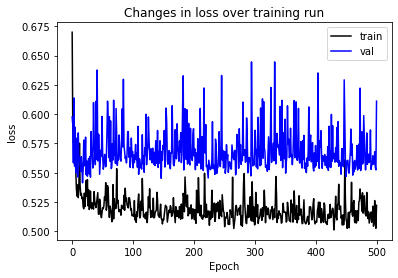

In [64]:
learning_plot(best_history, 'loss')

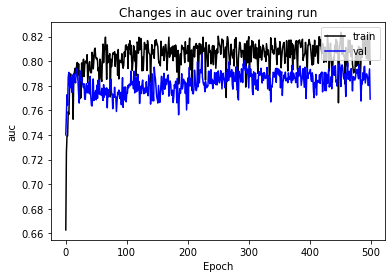

In [65]:
learning_plot(best_history, 'auc')

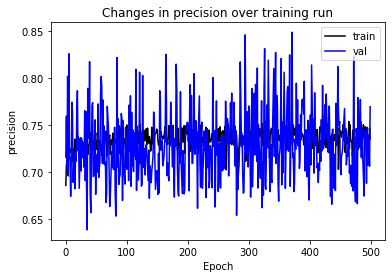

In [66]:
learning_plot(best_history, 'precision')

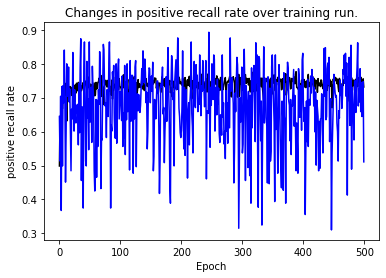

In [67]:
learning_recall(best_history, True)

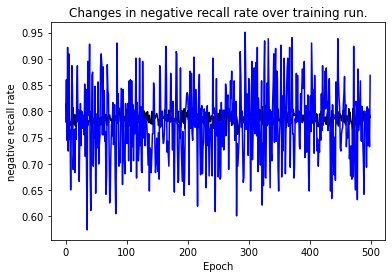

In [68]:
learning_recall(best_history, False)

In [69]:
loss = best_history.history['loss'][-1]
val_loss = best_history.history['val_loss'][-1]
print('Loss for training set is {}, while loss for validation set is {}. This gives a difference of {}'\
      .format(
              round(loss,4),
              round(val_loss,4), 
              round(val_loss-loss, 4))
             )

Loss for training set is 0.5221, while loss for validation set is 0.6111. This gives a difference of 0.089


In [70]:
auc = best_history.history['auc'][-1]
val_auc = best_history.history['val_auc'][-1]
print('AUC for training set is {}, while AUC for validation set is {}. This gives a difference of {}'\
      .format(round(auc, 2), round(val_auc, 2), round(auc-val_auc,2)))

AUC for training set is 0.8, while AUC for validation set is 0.77. This gives a difference of 0.03


In [71]:
true_positives_val = best_history.history['val_true_positives'][-1]
false_positives_val = best_history.history['val_false_positives'][-1]
true_negatives_val = best_history.history['val_true_negatives'][-1]
false_negatives_val = best_history.history['val_false_negatives'][-1]

val_conf_matrix = get_confusion_matrix(
                                       true_positives_val,
                                       false_positives_val,
                                       true_negatives_val,
                                       false_negatives_val
                                      )

print('Confusion_matrix:\n{}'.format(val_conf_matrix))

Confusion_matrix:
       1      0
1  214.0   64.0
0  205.0  422.0


In [72]:
print('True recall rate is {}'\
      .format(round(val_conf_matrix.loc['1', '1']/(val_conf_matrix.loc['1', '1']+val_conf_matrix.loc['0', '1']),2)))
print('Precision is {}'.format(best_history.history['val_precision'][-1]))

True recall rate is 0.51
Precision is 0.769784152507782


Looks very promising on validation set! Let's check test set

In [73]:
loss_test, precision_test, true_positives_test, true_negatives_test, false_positives_test, false_negatives_test, auc_test = best_model.evaluate(X_test, y_test)

36/36 [==============================] - 0s 1ms/step - loss: 0.5726 - precision: 0.7910 - true_positives: 265.0000 - true_negatives: 553.0000 - false_positives: 70.0000 - false_negatives: 244.0000 - auc: 0.7898


In [74]:
print('AUC for test set is {}.'.format(round(auc_test,2)))

AUC for test set is 0.79.


In [75]:
confusion_matrix = get_confusion_matrix(
                                        true_positives_test,
                                        false_positives_test,
                                        true_negatives_test,
                                        false_negatives_test
                                       )

In [76]:
print(confusion_matrix)

       1      0
1  265.0   70.0
0  244.0  553.0


In [77]:
print(
      'True recall rate is {}'\
      .format(round(
                    confusion_matrix.loc['1', '1']/
                    (confusion_matrix.loc['1', '1']+confusion_matrix.loc['0', '1']),
                    2
                   )
             )
     )
print('Precision is {}'.format(round(precision_test,2)))

True recall rate is 0.52
Precision is 0.79


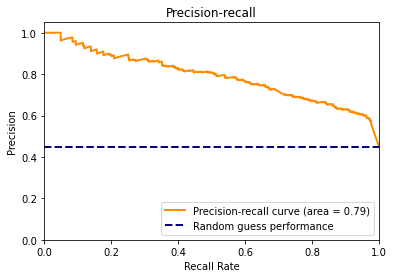

In [78]:
from sklearn import metrics
from sklearn.utils.class_weight import compute_sample_weight

# sample_weights = compute_sample_weight(class_weight='balanced', y=y_test)
random_pr = y_test.value_counts().iloc[1] / len(y_test)

predictions = best_model.predict(X_test)
precision, recall, thresholds = metrics.precision_recall_curve(y_test, predictions)
pr_auc = metrics.auc(recall, precision)

plt.figure()
lw = 2
plt.plot(
         recall, 
         precision, 
         color = 'darkorange',
         lw = lw, 
         label = 'Precision-recall curve (area = {})'.format(round(pr_auc,2))
        )
plt.plot([0, 1], [random_pr, random_pr], color='navy', lw=lw, linestyle='--', label='Random guess performance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall Rate')
plt.ylabel('Precision')
plt.title('Precision-recall')
plt.legend(loc = 'lower right')

# Save model

In [79]:
best_model.save('jazz_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: jazz_model\assets
